# Knowledge Graph Querying for Fixing invalid CVE-CWE mappings


In this tutorial, we will be providing the reader with the skills to process data (CVE,CWE and update history) and to run query functions on ampligraph that run on the pre-trained embedding models. 


In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import ampligraph
from ampligraph.discovery import query_topn
from ampligraph.evaluation import evaluate_performance
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

First and foremost, we are starting with importing the libraries as well as restoring the model trained on the NVD data that represents nodes and relationships. The model has been trained with 39.000+ triples; in our training process, we use the Adam optimizer, Multiclass NLL (Negative log-likelihood) Loss and LP regularizer. These parameters can be changed if you're training your embedding model.


In [2]:
from ampligraph.latent_features import restore_model
model_transe = restore_model('../files/kg_demo_model_transe_aug2021.pkl')
#model_transe = restore_model('../files/kg_demo_model_distmult_aug2021.pkl')
#model_transe = restore_model('../files/kg_demo_model_complex_aug2021.pkl')

On top of the embedding model, we need some of the datasets so that we can process them to use relationships and create query sets. These datasets include the CWE View list, CWE Category list, and CWE relationships provided in the MITRE CWE website. CWE-1003 list is the subset of CWE used in root cause mappings of vulnerabilities in the NVD. NVD exclusively uses this list therefore all of our predictions are within this list to match the validation set.


In [3]:
cwe_view = pd.read_csv("../files/cwe_view.csv")
cwe_category = pd.read_csv("../files/cwe_category.csv")
cwe_rels = pd.read_csv("../files/cwe_relations.csv")

In [4]:
df_cwe_1003 = pd.read_csv("../files/cwe-1003.csv", usecols = ['CWE-ID','Weakness Abstraction'], index_col=False)
df_cwe_1003.fillna('*', inplace=True)
df_cwe_1003.columns

Index(['CWE-ID', 'Weakness Abstraction'], dtype='object')

In [5]:
cwe_1003 = df_cwe_1003['CWE-ID'].to_list()

In [6]:
views = []

for i, item in cwe_view.iterrows():
    views.append([item['ID'],item['Name'],item['Has_Member']])
    
categories = []

for i, item in cwe_category.iterrows():
    categories.append([item['ID'],item['Name'],item['Has_Member']])

For the validation of our predictions, we use the updated mappings in the NVD. This dataset was obtained in December 2024 from the NVD archives. It can be updated using the script here []. #todo: add ref to the script

Filtered query document provides the CWE items and the CVE's that these are mapped to. Created for ease of processing. 


In [7]:
new_cve_df = pd.read_csv('../files/cve2cwe_2024.csv')

This tutorial works on the 'Discouraged' CWE correction, we also provide the filtered query files for the 'Prohibited' CWE correction that can be found in the same tutorial folder. You can replace the filenames (here or after Checkpoint #2.

In [8]:
df_query = pd.read_csv('../files/filtered_query_disc.csv', usecols = ['CWE','CVE'])

In [9]:
cwe_dict = {}
for i, row in cwe_rels.iterrows():
    child = row['Child']
    parent = row['Parent']
    rel = row['Relationship']
    
    if rel == 'ChildOf':
        if child in cwe_dict:
            cwe_dict[child].append(parent)
        else:
            cwe_dict[child] = []
            cwe_dict[child].append(parent)

In [10]:
# This is the first method I implemented to find family of the CWE. Usually, this yields a 
# large list of CWE that are related to each other, since we are returning the whole branch
# that CWE is in. Rather, we can also just return direct parents and children (get_direct_family method). 
# Both are used for coarse and fine grain prediction evaluations.

def get_cwe_parents(cwe):
    #given a cwe, find all related cwe that are in the same branch.
    family = []
    
    if cwe in cwe_dict:
        # exists as key - has parents.
        value = cwe_dict[cwe]
        for item in value:
            family.append(item)
            res = get_cwe_family(item) #recursively reach boss parent
            if res:
                family.extend(res)
    return family

def get_cwe_children(cwe):
    family = []
    
    if any(cwe in val for val in cwe_dict.values()):
        keys = [key for key, value in cwe_dict.items() if cwe in value]
        #print(keys)
        family.extend(keys)
        for item in keys:
            res = get_cwe_children(item)  
            if res:
                family.extend(res)
    return family
    
def get_cwe_family(cwe):
    return set(get_cwe_parents(cwe) + get_cwe_children(cwe))

def get_direct_family(cwe):
    family = []
    
    if cwe in cwe_dict:
        # exists as key - has parents.
        value = cwe_dict[cwe]
        for item in value:
            family.append(item)
    if any(cwe in val for val in cwe_dict.values()):
        keys = [key for key, value in cwe_dict.items() if cwe in value]
        #print(keys)
        family.extend(keys)
    return family

In [11]:
def strtoList(string):
    ret = []
    arr = string.split("'")
    for i in arr:
        if len(i)>3:
            ret.append(i)
    return ret

## Checkpoint 1: Running the queries for each CWE-CVE pair. 

In this checkpoint you can run your own queries. 
BE AWARE that it will take a while to compute. On a CPU it took several hours to finish. Our test set includes 500+ queries.

You can play with:
- Model selection: We are using a pre-trained TransE model. Other options from our tutorials are DistMult or ComplEx. 
- Query top N: We query for top 10 results. This obviously cuts down on the accuracy, but larger numbers like 20 take much longer to compute and it may be impractical for the reviewer to sift through 20 suggestions compared to 10.
- head, relation, tail: For our queries, we are looking at CVE-MatchingCWE-CWE triples. For other triples, these fields can be modified. 
- ents_to_consider: This set defines the initial subset of candidates your model will compute the scores for. If insufficient, the model can also look at other candidates, which happens if you provide a candidate set less than your N value (e.g. 10).
- rels_to_consider: we do not use this option since our query is not for links but rather it's for nodes.


In [ ]:
results = {}

In [ ]:
# Run this if it was not ran before - takes a while to compute

for i, pair in df_query.iterrows():
    cwe_q = pair['CWE']
    cve_q = pair['CVE']
    #print(cwe_q )#, "CVE = ", cve_q)
    child_cwes = get_cwe_children(cwe_q)
    
    for cve in strtoList(cve_q):
        try:
            res = query_topn(model_transe,10,head=cve,relation="MatchingCWE", tail=None,
                           ents_to_consider=child_cwes, rels_to_consider=None)
            results[cve] = res
            #print(res)
        except:
            pass

Export your results to a pickle file or to a csv file to avoid running the prev step for each time you run the rest of the tutorial. 


In [ ]:
import pickle

# Store data (serialize)
with open('query_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
res_list = []

for key in results:
    
    rank = results[key][0]
    score = results[key][1]
    res_list.append((key, rank,score))

In [ ]:
# Save the DataFrame to a CSV file
df_res = pd.DataFrame(res_list, columns=['CVE','Rank','Score'])
df_res.to_csv('cwe_disc_query.csv', index=False)

## Checkpoint 2: Evaluating the query results

Start here and skip checkpoint 1 if you already have the results for the quer set. 

We continue with defining the discouraged CWE set and processing the query results to 

In [12]:
df_res = pd.read_csv('../files/cwe_disc_query.csv')
#df_res

In [13]:
cwe_disc = ["CWE-119","CWE-20","CWE-200","CWE-269","CWE-289",
"CWE-311","CWE-330","CWE-345","CWE-74","CWE-400","CWE-610","CWE-662",
"CWE-665","CWE-668","CWE-682","CWE-697","CWE-755","CWE-834"]

In [14]:
count = 0
overall = 0
disc = 0

updated_cve = []
missed_cve = []
family_cve = []
other_cve = []
disc_cve = []

for index, row in df_res.iterrows():
    cve = row["CVE"]
    res = row["Rank"].split('\n')
    scores = row["Score"].split('\n')
    
    row = new_cve_df.loc[new_cve_df["subject:START_ID"] == cve]
    cwe_match = row["object:END_ID"].values
    
    for item in cwe_match:
        overall +=1
        cnt = 1
        found = False
        if item not in cwe_disc:
            #now that we have an upadate match for this CVE, compare the results to the updated value
            
            for rank in res:
                q = rank.split("'")
                cve = q[1]
                cwe = q[5]
                
                if item == cwe:
                    found = True
                    break
                cnt = cnt + 1
                
            if found: 
                updated_cve.append((cve, item, cnt))
                count += 1
            else:
                # missed_cve.append(cve)
                # In this case the exact CWE cannot be found among the top 10 predictions.
                # So we do a coarse-grain match to see if parent/child CWE are predicted.
                
                fam = get_direct_family(item)
                fam_all = get_cwe_family(item)
                
                for i in fam: 
                # find if the close family members are predicted by KG
                    found = False
                    cnt = 1
                    for rank in res:
                        q = rank.split("'")
                        cve = q[0]
                        cwe = q[2]

                        if i == cwe: # i is the cwe in family
                            found = True
                            break
                        cnt = cnt + 1
                    if found: 
                        missed_cve.append((cve, i, cnt))
                    else:   
                        for i in fam_all: 
                        # find if the biggg family members are predicted by KG
                            found = False
                            cnt = 1
                            for rank in res:
                                q = rank.split("'")
                                cve = q[1]
                                cwe = q[5]

                                if i == cwe: # i is the cwe in family
                                    found = True
                                    break
                                cnt = cnt + 1
                            if found: 
                                family_cve.append((cve, i, cnt))
                            else:
                                other_cve.append(cve)

        else:
            disc += 1
            #print(item)
            #print(res)
            for rank in res:
                q = rank.split("'")
                cve = q[1]
                cwe = q[5]
                
                if item == cwe:
                    found = True
                    break
                cnt = cnt + 1
                
            if found: 
                disc_cve.append((cve, item, cnt))
                count += 1
                
            else:
                other_cve.append(cve)

For our test set, we see that there are overall 1591 queries, of which 877 are mapped to discouraged (but still valid) CWE. 'count' is the number of CWE the model can predict among top 10 results. 

In [15]:
print(count, overall, disc)

172 1591 877


## Checkpoint 3

In [16]:
# using df_cwe_cate or df_cwe_view for querying for CWEs in that list (that can be used to map CVEs i.e. in CWE-1003 list)

def get_cwe_subtree(cweid):
    cwe_ret = []
    cwe_members = get_cwe_children(cweid)
    for item in cwe_members:
        if item in cwe_1003:
            cwe_ret.append(item)
    return cwe_ret

In [17]:
df_cve2cwe = pd.read_csv('../files/df_cve2cwe.csv', usecols = ['CVE','CWE'])
#df_cve2cwe

In [18]:
list_unpred = set()

df = pd.DataFrame(columns = ['CVE','CWE'])

for i in set(other_cve): # CVE for which we cannot predict CWE at top10 predictions
    rows = df_cve2cwe.loc[df_cve2cwe['CVE']==i]
    for idx,row in rows.iterrows():
        #print(row)
        cwe = row['CWE']
        list_unpred.add(cwe)
        df.loc[len(df)] = [i,cwe]

The next cell is to check for the mappings that the model could not correctly predict. We see if they had any members in the CWE-1003 list, if not, the model cannot predict the correct CWE for those. For all 101, we see that they had no members in the CWE-1003 list, therefore these will be excluded from the overall accuracy evaluations

In [19]:
cnt_no = 0
cnt_f = 0
cnt = 0
for item in list_unpred:
    cwe_subtree = get_cwe_subtree(item)
    #size = len(df.loc[df['CWE']==item])
    
    if len(cwe_subtree) == 0:
        cnt_no += 1
    elif len(cwe_subtree) < 5:
        cnt_f += 1
    else:
        cnt+= 1
        #print(item, len(cwe_subtree)) #none of them have members that are also in the CWE-1003 list. 
        
print(cnt_no, cnt_f, cnt)      

101 0 0


The following cell will give an error for the 'Discouraged' set since the array 'missed_cve' is empty. It can be run for the 'Prohibited' set's evaluation.

In [24]:
uniq_fam = []
prev = missed_cve[0][0]
mindex = 10
minpred = ''
for i in missed_cve: #family_cve for coarse, missed_cve for fine granularity
    # Sometimes there are multiple matches for the same cve, since there are multiple CWE mappings
    #print(i)

    if i[0] == prev:
        rank = i[2]
        #print(rank)
        if rank < mindex:
            mindex = rank
            minpred = i
    else:
        #print(minpred)
        uniq_fam.append(minpred) #push prev min
        
        prev = i[0]
        mindex = i[2]
        minpred = i

IndexError: list index out of range

In [25]:
prev = family_cve[0][0]
uniq_fam2 = []
mindex = 10
minpred = ''
for i in family_cve: #family_cve for coarse, missed_cve for fine granularity
    # Sometimes there are multiple matches for the same cve, since there are multiple 
    #print(i)

    if i[0] == prev:
        rank = i[2]
        #print(rank)
        if rank < mindex:
            mindex = rank
            minpred = i
    else:
        #print(minpred)
        uniq_fam2.append(minpred) #push prev min
        
        prev = i[0]
        mindex = i[2]
        minpred = i

Write results to output, again for 'Discouraged' set, skip writing df_miss, since it will result in an error.

In [28]:
df = pd.DataFrame(updated_cve, columns = ['CVE','CWE','Rank'])
#df.to_csv('cve_disc_24.csv',index=False)

In [29]:
df_missFine = pd.DataFrame(uniq_fam, columns = ['CVE','CWE','Rank'])
#df_missFine.to_csv('cve_finedisc_24.csv',index=False)

In [30]:
df_missCoarse = pd.DataFrame(uniq_fam2, columns = ['CVE','CWE','Rank'])
#df_missCoarse.to_csv('cve_coarsedisc_24.csv',index=False)

In [33]:
df_discPred = pd.DataFrame(disc_cve, columns = ['CVE','CWE','Rank']) # the updated value was discouraged for these
#df_discpred.to_csv('cve_discdisc_24.csv',index=False)

## Checkpoint 4: Evaluation

Combine all results (exact match, fine grain and coarse grain) for evaluation. Then we'll use these for different plots. 

In [35]:
overall_df = pd.concat([df, df_missCoarse, df_discPred]) # add df_missFine when running eval for 'Prohibited'

In [36]:
import matplotlib.pyplot as plt

ranks --> the exact match ranks

In [37]:
ranks = df['Rank'].tolist()
a = mr_score(ranks)
b = mrr_score(ranks)
print(a,b)

1.0393700787401574 0.9803149606299213


ranks2 --> the fine grain match ranks

In [38]:
ranks2 = df_missFine['Rank'].tolist()
a = mr_score(ranks2)
b = mrr_score(ranks2)
print(a,b)

nan nan


ranks3 --> the coarse grain ranks

In [39]:
ranks3 = df_missCoarse['Rank'].tolist()
a = mr_score(ranks3)
b = mrr_score(ranks3)
print(a,b)

1.4008097165991902 0.9016306792622583


In [44]:
ranks4 = df_discPred['Rank'].tolist()
a = mr_score(ranks4)
b = mrr_score(ranks4)
print(a,b)

1.0 1.0


The below plot shows the distribution of the ranks for all of the predicted CWE (exact, fine, coarse, and discouraged)

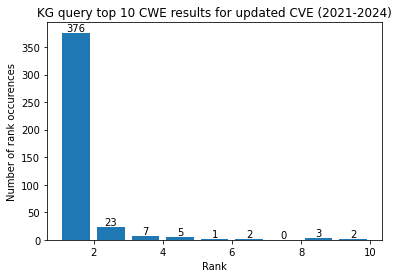

In [45]:
counts, edges, bars = plt.hist(ranks+ranks3+ranks4,rwidth=0.8, bins=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.bar_label(bars)
plt.xlabel("Rank")
plt.ylabel("Number of rank occurences")
plt.title("KG query top 10 CWE results for updated CVE (between 2021-2024)")
plt.show()